# Data Quality

In [1]:
from src.setup import *
%load_ext rpy2.ipython

In [2]:
%%capture --no-stdout err
%%R 
library(gridExtra)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down


## Missing Data

In [3]:
df = pd.read_parquet('data/usa_names.parq') 
df

,Age,Gender,Name,Favorite_Color,Favorite_Flower
0,48,F,Lisa,Yellow,Daisy
1,62,F,Karen,Green,Rose
2,26,M,Michael,Purple,None
3,73,F,Patricia,Red,Orchid
...,...,...,...,...,...
6338,11,M,Jacob,Red,Lily
6339,20,M,Jacob,Green,Rose
6340,72,M,Robert,Blue,Lily
6341,64,F,Debra,Purple,Rose


In [4]:
with show_more_rows():
    print(df.describe(include='all'))

                Age Gender     Name Favorite_Color Favorite_Flower
count   6342.000000   6342     6342           5599            5574
unique          NaN      2       69              6               5
top             NaN      F  Michael         Yellow          Orchid
freq            NaN   3190      535            965            1356
mean      42.458846    NaN      NaN            NaN             NaN
std       27.312662    NaN      NaN            NaN             NaN
min        2.000000    NaN      NaN            NaN             NaN
25%       19.000000    NaN      NaN            NaN             NaN
50%       39.000000    NaN      NaN            NaN             NaN
75%       63.000000    NaN      NaN            NaN             NaN
max      101.000000    NaN      NaN            NaN             NaN


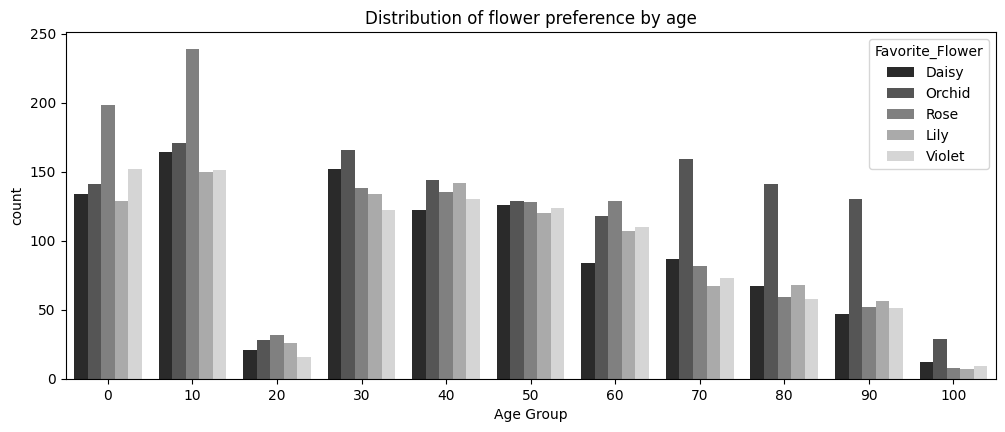

In [5]:
df['Age Group'] = df.Age//10 * 10
fig, ax = plt.subplots(figsize=(12, 4.5))
sns.countplot(x="Age Group", hue="Favorite_Flower", 
              ax=ax, palette='gray', data=df)
ax.set_title("Distribution of flower preference by age")
plt.savefig("img/(Ch05)Distribution of flower preference by age.png")

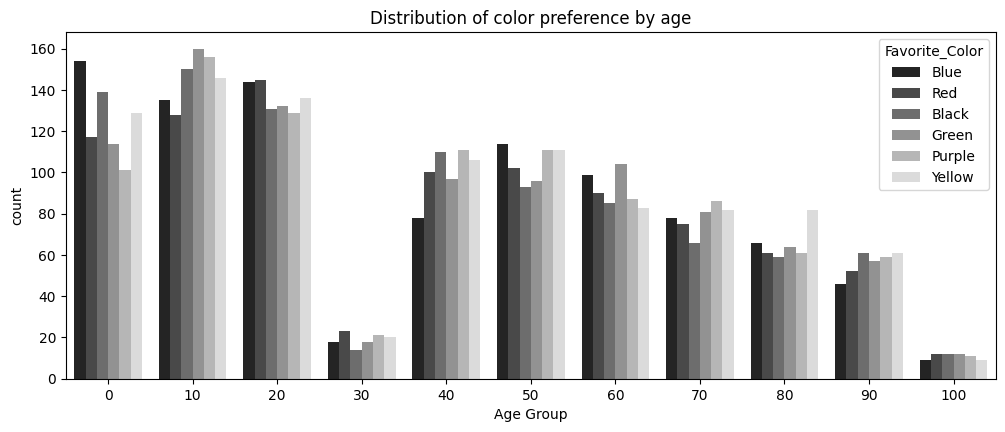

In [6]:
fig, ax = plt.subplots(figsize=(12, 4.5))
sns.countplot(x="Age Group", hue="Favorite_Color", 
              ax=ax, palette='gray', data=df)
ax.set_title("Distribution of color preference by age")
plt.savefig("img/(Ch05)Distribution of color preference by age.png")

## Biasing trends

### Understanding Bias

In [7]:
names = pd.read_parquet('data/usa_names_states.parq')
names['Age Group'] = names.Age//10 * 10
names

,Age,Birth_Month,Name,Gender,Home,Age Group
0,17,June,Matthew,M,Hawaii,10
1,5,September,Emma,F,West Virginia,0
2,4,January,Liam,M,Alaska,0
3,96,March,William,M,Arkansas,90
...,...,...,...,...,...,...
6338,29,August,Jessica,F,Massachusetts,20
6339,51,April,Michael,M,Wyoming,50
6340,29,May,Christopher,M,North Carolina,20
6341,62,November,James,M,Texas,60


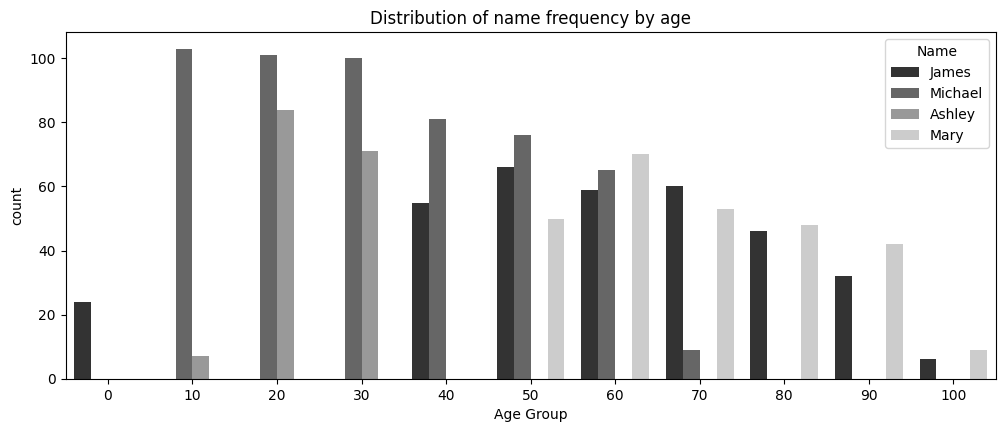

In [8]:
fig, ax = plt.subplots(figsize=(12, 4.5))
somenames = ['Michael', 'James', 'Mary', 'Ashley']
popular = names[names.Name.isin(somenames)]
sns.countplot(x="Age Group", hue="Name", 
              ax=ax, palette='gray', data=popular)
ax.set_title("Distribution of name frequency by age")
plt.savefig("img/(Ch05)Distribution of name frequency by age.png")

### Detecting Bias

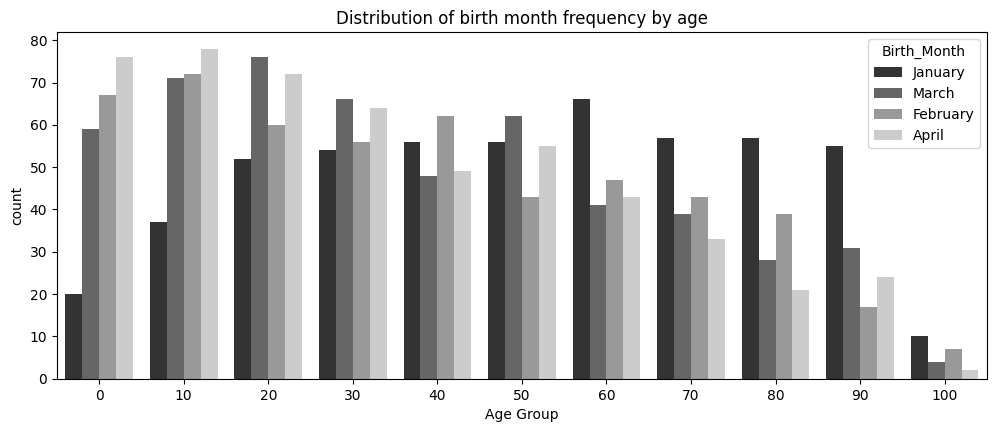

In [9]:
fig, ax = plt.subplots(figsize=(12, 4.5))
months = ['January', 'February', 'March', 'April']
popular = names[names.Birth_Month.isin(months)]
sns.countplot(x="Age Group", hue="Birth_Month", 
              ax=ax, palette='gray', data=popular)
ax.set_title("Distribution of birth month frequency by age")
plt.savefig("img/(Ch05)Distribution of birth month frequency by age.png")

In [10]:
by_month = (names
    .groupby('Age Group')
    .Birth_Month
    .value_counts()
    .unstack())

by_month = by_month[month_names]
by_month

Birth_Month,January,February,March,April,May,June,July,August,September,October,November,December
Age Group,,,,,,,,,,,,
0,20,67,59,76,66,77,71,65,67,67,56,63
10,37,72,71,78,70,73,82,81,83,79,70,79
20,52,60,76,72,65,65,71,66,68,75,76,71
30,54,56,66,64,73,58,87,82,66,65,57,58
...,...,...,...,...,...,...,...,...,...,...,...,...
70,57,43,39,33,39,36,45,34,38,30,37,37
80,57,39,28,21,31,37,23,28,27,31,34,37
90,55,17,31,24,21,23,30,29,33,25,28,20
100,10,7,4,2,6,2,4,6,5,5,7,7


In [11]:
with show_more_rows():
    print(by_month.var(axis=1) / by_month.sum(axis=1))

Age Group
0      0.289808
10     0.172563
20     0.061524
30     0.138908
40     0.077120
50     0.059772
60     0.169321
70     0.104118
80     0.227215
90     0.284632
100    0.079604
dtype: float64


### Comparison to Baselines

In [12]:
states = pd.read_fwf('data/state-population.fwf')
states

,State,Population_2019,Population_2010,House_Seats
0,California,39512223,37254523,53.0
1,Texas,28995881,25145561,36.0
2,Florida,21477737,18801310,27.0
3,New York,19453561,19378102,27.0
...,...,...,...,...
52,Guam,165718,159358,0.5
53,U.S. Virgin Isl,104914,106405,0.5
54,American Samoa,55641,55519,0.5
55,N. Mariana Isl,55194,53883,0.5


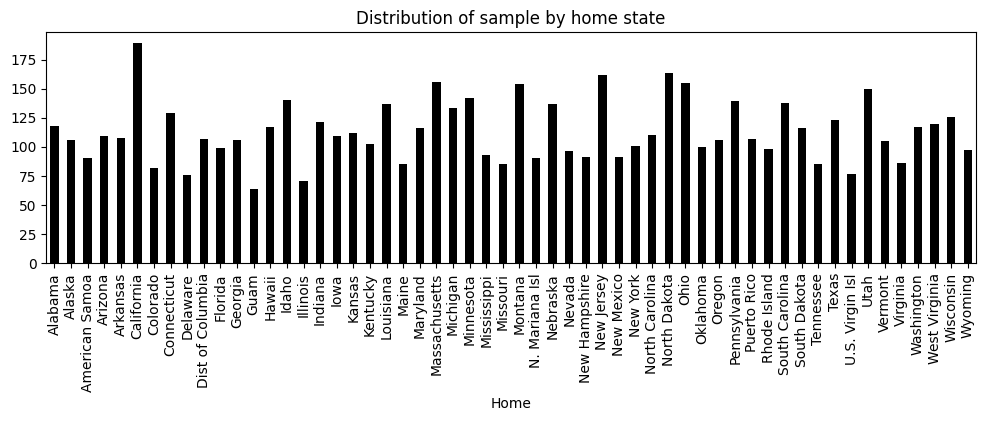

In [13]:
(names
    .Home
    .value_counts()
    .sort_index()
    .plot(kind='bar', figsize=(12, 3), 
          title="Distribution of sample by home state")
)
plt.savefig("img/(Ch05)Distribution of sample by home state.png")

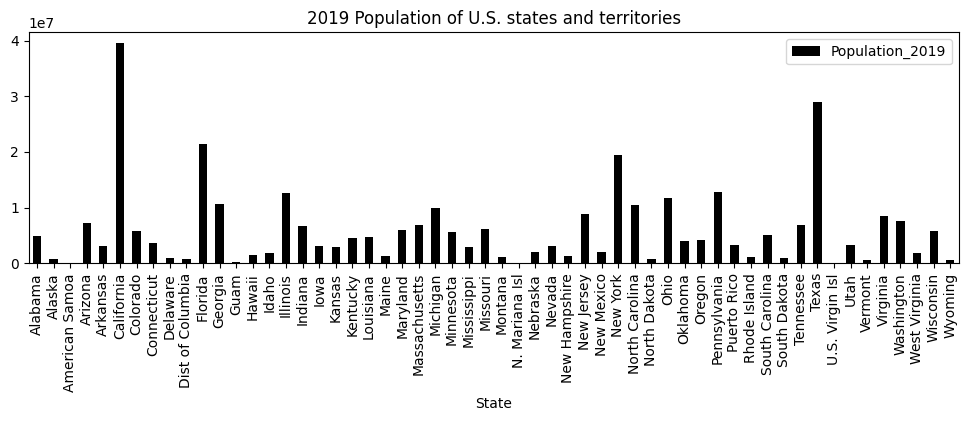

In [14]:
(states
    .sort_values('State')
    [['State', 'Population_2019']]
    .set_index('State')
    .plot(kind='bar', figsize=(12, 3),
          title="2019 Population of U.S. states and territories")
)
plt.savefig("img/(Ch05)2019 Population of U.S. states and territories.png")

### Benford's Law

In [15]:
cities = pd.read_fwf('data/us-cities.fwf')
cities

,NAME,POP2019,AREA_KM2
0,New York City,8336817,780.9
1,Los Angeles,3979576,1213.9
2,Chicago,2693976,588.7
3,Houston,2320268,1651.1
...,...,...,...
313,Vacaville,100670,75.1
314,Clinton,100471,72.8
315,Bend,100421,85.7
316,Woodbridge,100145,60.3


In [16]:
pop_digits =  cities.POP2019.astype(str).str[0].value_counts()
with show_more_rows():
    print(pop_digits)

POP2019
1    206
2     53
3     20
4     10
6      9
5      8
8      5
9      3
7      3
Name: count, dtype: int64


In [17]:
area_digits =  cities.AREA_KM2.astype(str).str[0].value_counts()
with show_more_rows():
    print(area_digits)

AREA_KM2
1    118
2     47
3     31
4     23
8     21
9     21
7     20
6     20
5     16
Name: count, dtype: int64


## Class imbalance

In [18]:
%%bash
zcat data/gnosis/*.log.gz | 
    cut -d' ' -f9 | 
    sort | 
    uniq -c

  10280 200
      2 206
    398 301
   1680 304
    181 403
    901 404
      9 500


In [19]:
%%bash
zcat data/gnosis/20200330.log.gz | head -1 | fmt -w50

162.158.238.207 - - [30/Mar/2020:00:00:00 -0400]
"GET /TPiP/024.code HTTP/1.1" 200 75


In [20]:
def apache_log_to_df(fname):
    # Read one log file.  Treat is as a space separated file
    # There is no explicit header, so we assign columns
    cols = ['ip_address', 'ident', 'userid', 'timestamp', 
            'tz', 'request', 'status', 'size']
    df = pd.read_csv(fname, sep=' ', header=None, names=cols)
    
    # The first pass gets something workable, but refine it
    # Datetime has superfluous '[', but fmt matches that
    fmt = "[%d/%b/%Y:%H:%M:%S"
    df['timestamp'] = pd.to_datetime(df.timestamp, format=fmt)
    
    # Convert timezone to an integer
    # Not general, I know these logs use integral timezone
    # E.g. India Standard Time (GMT+5:30) would break this
    df['tz'] = df.tz.str[:3].astype(int)
    
    # Break up the quoted request into sub-components
    df[['method', 'resource', 'protocol']] = (
                df.request.str.split(' ', expand=True))
    
    # Break the IP address into each quad
    df[['quad1', 'quad2', 'quad3', 'quad4']] = (
                df.ip_address.str.split('.', expand=True))
    
    # Pandas lets us pull components from datetime
    df['hour'] = df.timestamp.dt.hour
    df['minute'] = df.timestamp.dt.minute
    
    # Split resource into the path/directory vs. actual page
    df[['path', 'page']] = (
                df.resource.str.rsplit('/', n=1, expand=True))
    # Only care about some fields for current purposes
    cols = ['hour', 'minute', 
            'quad1', 'quad2', 'quad3', 'quad4', 
            'method', 'path', 'page', 'status']
    return df[cols]

In [21]:
reqs = pd.concat(map(apache_log_to_df, 
                 glob('data/gnosis/*.log.gz')))
# Each file has index from 0, so dups occur in raw version
reqs = reqs.reset_index().drop('index', axis=1)
# The /16 subnetwork is too random for this purpose
reqs.drop(['quad3', 'quad4'], axis=1, inplace=True)
reqs

,hour,minute,quad1,quad2,method,path,page,status
0,0,9,173,245,GET,/publish,,200
1,0,9,173,245,GET,/publish,eye.ico,304
2,0,9,172,69,GET,/publish/images,gopher.gif,304
3,0,9,172,69,GET,/publish/images,doc.gif,304
...,...,...,...,...,...,...,...,...
13447,23,41,162,158,GET,/cleaning/stats,QUICK.html,200
13448,23,45,108,162,GET,/cleaning/stats,DAILYSUM.html,200
13449,23,45,162,158,GET,/cleaning/stats,DAILYSUM_bar3d.png,200
13450,23,50,162,158,GET,/TPiP,024.code,200


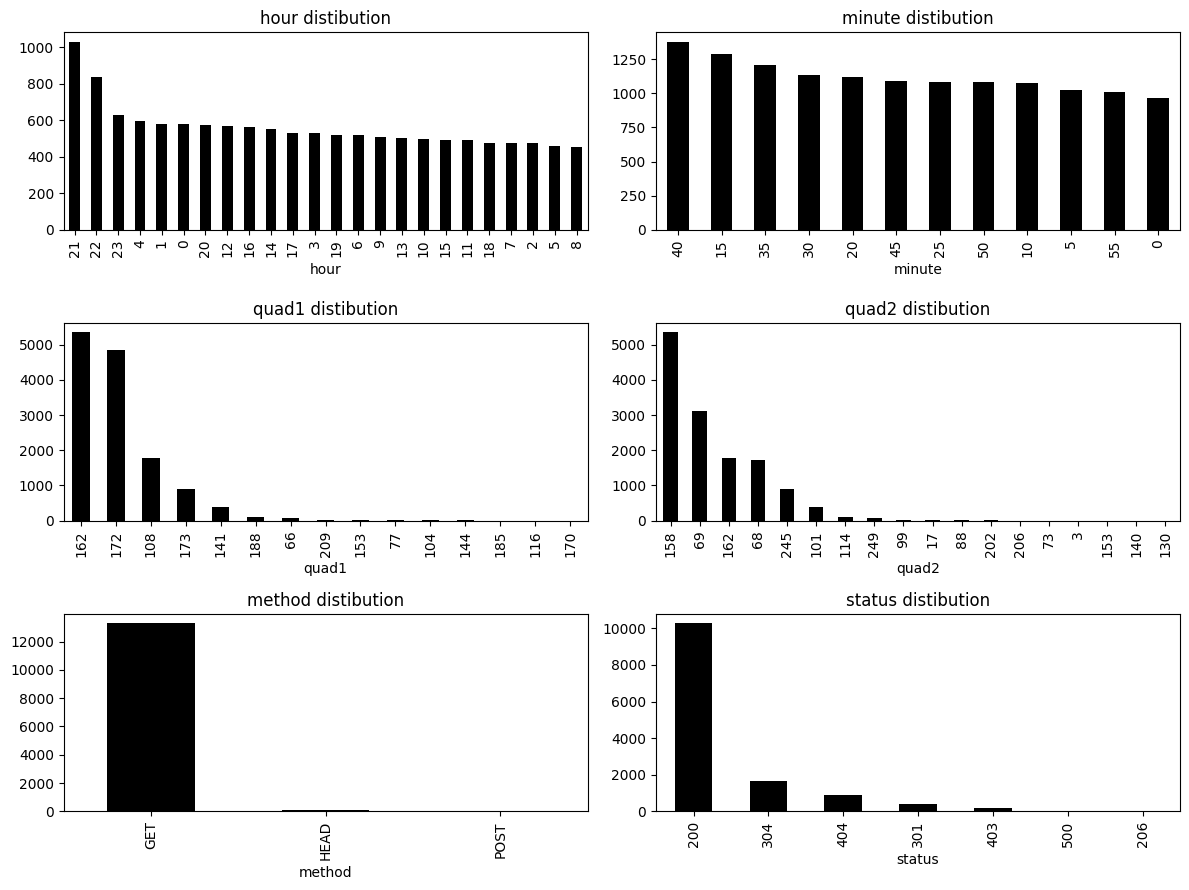

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(12, 9))

# Which factors should we analyze for class balance?
factors = ['hour', 'minute', 'quad1', 'quad2', 'method', 'status']

# Loop through the axis subplots and the factors
for col, ax in zip(factors, axes.flatten()):
    # Minute is categorical but too many so quantize
    if col == 'minute':
        data = (reqs[col] // 5 * 5).value_counts()
    else:
        data = reqs[col].value_counts()
    data.plot(kind='bar', ax=ax)
    ax.set_title(f"{col} distibution")

# Matplotlib trick to improve spacing of subplots
fig.tight_layout()
plt.savefig("img/(Ch05)web-traffic feature distributions.png")

## Normalization and scaling

In [23]:
unscaled = make_unscaled_features()
unscaled

,Feature_1,Feature_2,Target
0,0.112999,19247.756104,11.407035
1,0.204178,23432.270613,20.000000
2,0.173678,19179.445753,17.336683
3,0.161411,17579.625264,16.633166
...,...,...,...
196,0.137692,20934.654450,13.316583
197,0.184393,18855.241195,18.241206
198,0.177846,19760.314890,17.839196
199,0.145229,20497.722353,14.371859


In [24]:
unscaled.corr()

,Feature_1,Feature_2,Target
Feature_1,1.000000,-0.272963,0.992514
Feature_2,-0.272963,1.000000,-0.269406
Target,0.992514,-0.269406,1.000000


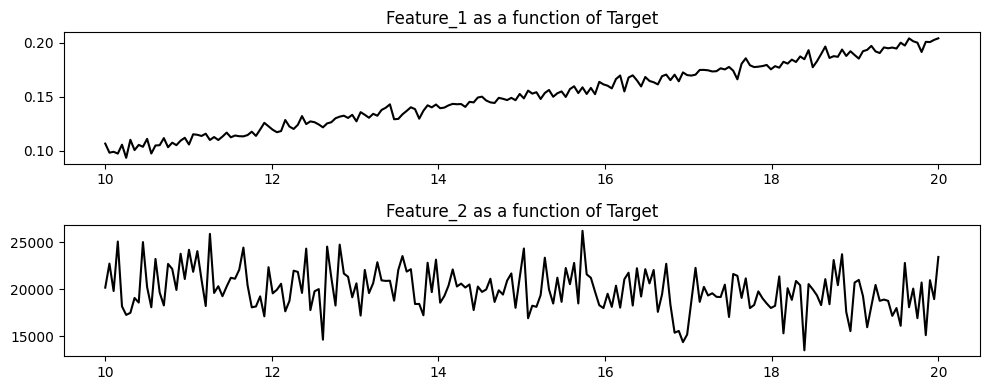

In [25]:
plot_univariate_trends(unscaled)

### Applying a Machine Learning Model

In [26]:
from sklearn.model_selection import train_test_split

X = unscaled.drop('Target', axis=1)
y = unscaled['Target']

X_train, X_test, y_train, y_test = (
    train_test_split(X, y, random_state=1))

In [27]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(X_train, y_train).score(X_test, y_test)

0.027756186064182953

In [28]:
from sklearn.preprocessing import MinMaxScaler
X_new = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = (
    train_test_split(X_new, y, random_state=1))

knn2 = KNeighborsRegressor()
knn2.fit(X_train, y_train).score(X_test, y_test)

0.9743878175626131

### Scaling Techniques

In [29]:
%%R -i X,X_new
# Import the data frame/array from Python
py_raw_data <- X$Feature_1  # only feature 1
py_scaled <- X_new[,1]      # scaled column 1

# Utility function to scale as [0, 1]
normalize <- function(x) {
    floor <- min(x)  # Only find min once
    return ((x - floor) / (max(x) - floor))
}

# Scale the raw data
r_scaled <- normalize(py_raw_data)

# Near equality of elements from normalize() and MinMaxScaler
all.equal(py_scaled, r_scaled)

[1] TRUE


In [30]:
%%R
print("A few 'equalities':")
print(py_scaled[1:5])
print(r_scaled[1:5])

print("Exactly equal?")
print((py_scaled == r_scaled)[1:10])

print("Mean absolute difference:")
print(mean(abs(py_scaled - r_scaled)))

[1] "A few 'equalities':"
[1] 0.1776148 1.0000000 0.7249096 0.6142706 0.8920478
[1] 0.1776148 1.0000000 0.7249096 0.6142706 0.8920478
[1] "Exactly equal?"
 [1]  TRUE FALSE FALSE FALSE FALSE  TRUE FALSE  TRUE  TRUE  TRUE
[1] "Mean absolute difference:"
[1] 6.130513e-17


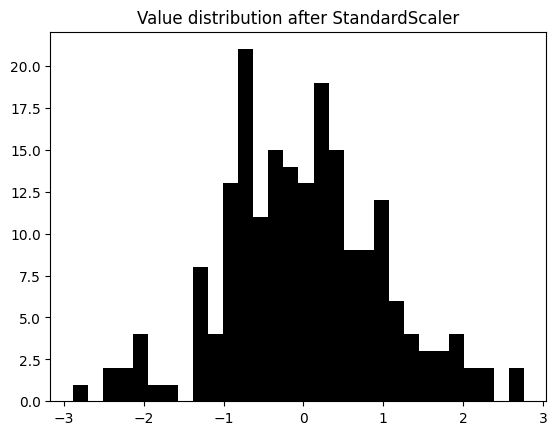

In [31]:
from sklearn.preprocessing import StandardScaler
X_new2 = StandardScaler().fit_transform(X)

# Second column for example (both were scaled)
plt.hist(X_new2[:, 1], bins=30)
plt.title("Value distribution after StandardScaler")
plt.savefig("img/(Ch05)Value distribution after StandardScaler.png")

In [32]:
%%R -i X,X_new2
# Import the data frame/array from Python
py_raw_data <- X$Feature_2  # Only feature 2
py_scaled <- X_new2[, 2]    # scaled column 2

r_scaled = (py_raw_data - mean(py_raw_data)) / 
            sd(py_raw_data)

all.equal(py_scaled, r_scaled)

[1] "Mean relative difference: 0.002503133"


In [33]:
%%R
print("Mean from R scaling:")
print(mean(r_scaled))

print("Standard deviation:")
print(sd(r_scaled))

print("Almost equal with tolerance 0.005")
all.equal(py_scaled, r_scaled, tolerance = 0.005)

[1] "Mean from R scaling:"
[1] 6.591949e-17
[1] "Standard deviation:"
[1] 1
[1] "Almost equal with tolerance 0.005"
[1] TRUE


In [34]:
X['Feature_3'] = X.Feature_1
X.loc[0, 'Feature_3'] = 100

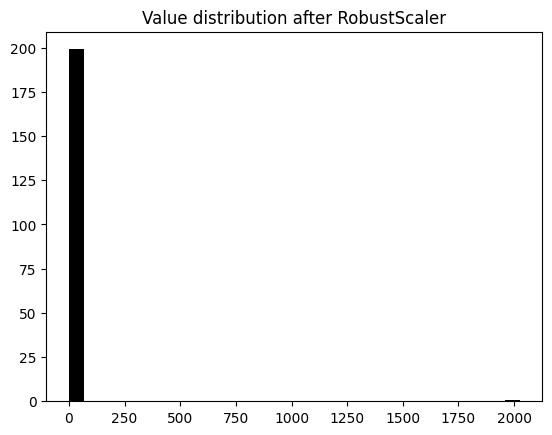

In [35]:
from sklearn.preprocessing import RobustScaler
X_new3 = RobustScaler().fit_transform(X)

# Third column for example (all were scaled)
plt.hist(X_new3[:, 2], bins=30)
plt.title("Value distribution after RobustScaler")
plt.savefig("img/(Ch05)Value distribution after RobustScaler.png")

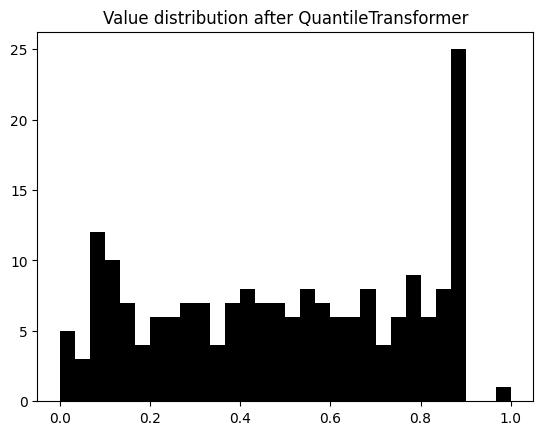

In [36]:
from sklearn.preprocessing import QuantileTransformer
# Ten quantiles is also called "decile"
deciles = QuantileTransformer(n_quantiles=10)
X_new4 = deciles.fit_transform(X)

# Third column for example (all were scaled)
plt.hist(X_new4[:, 2], bins=30)
plt.title("Value distribution after QuantileTransformer")
plt.savefig("img/(Ch05)Value distribution after QuantileTransformer.png")

### Factor and Sample Weighting

In [37]:
reqs.sample(8, random_state=72).drop('page', axis=1)

,hour,minute,quad1,quad2,method,path,status
3347,19,2,172,68,GET,/TPiP,200
2729,6,19,162,158,GET,/download/Gnosis_Utils.More,200
8102,2,21,172,69,GET,/publish/images,304
9347,13,13,172,68,GET,/download/relax,200
6323,2,20,162,158,GET,/publish,403
2352,22,59,162,158,GET,/TPiP,200
12728,22,56,141,101,GET,/juvenilia,304
12235,9,40,108,162,GET,/publish,304


In [38]:
reqs.method.value_counts()

method
GET     13294
HEAD      109
POST       48
Name: count, dtype: int64

In [39]:
# The row index positions for rows to overweight
tpip_rows = reqs[reqs.path == '/TPiP'].index
head_rows = reqs[reqs.method == 'HEAD'].index
post_rows = reqs[reqs.method == 'POST'].index

# Configure the weights in a copy of data frame
reqs_weighted = reqs.copy()
reqs_weighted['weight'] = 1  # Default weight of one
reqs_weighted.loc[tpip_rows, 'weight'] = 5
reqs_weighted.loc[head_rows, 'weight'] = 122
reqs_weighted.loc[post_rows, 'weight'] = 277

# Do not use column page in the model
reqs_weighted.drop('page', axis=1, inplace=True)

# View the configured weights
reqs_weighted.sample(4, random_state=72)

,hour,minute,quad1,quad2,method,path,status,weight
3347,19,2,172,68,GET,/TPiP,200,5
2729,6,19,162,158,GET,/download/Gnosis_Utils.More,200,1
8102,2,21,172,69,GET,/publish/images,304,1
9347,13,13,172,68,GET,/download/relax,200,1


In [40]:
target_weight = {code:1 for code in reqs.status.unique()}
target_weight[404] = 10
target_weight

{np.int64(200): 1,
 np.int64(304): 1,
 np.int64(403): 1,
 np.int64(404): 10,
 np.int64(301): 1,
 np.int64(500): 1,
 np.int64(206): 1}

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder

# Create the model object with target weights
rfc = RandomForestClassifier(class_weight=target_weight,
                             random_state=0)

# Select and encode the features and target
X = reqs_weighted[['hour', 'minute', 
                   'quad1', 'quad2',
                   'method', 'path']]

# Encode strings as ordinal integers
X = OrdinalEncoder().fit_transform(X)
y = reqs_weighted['status']
weight = reqs_weighted.weight

# Perform the train/test split, including weights
X_train, X_test, y_train, y_test, weights_train, _ = (
     train_test_split(X, y, weight, random_state=1))

# Fit the model on the training data and score it
rfc.fit(X_train, y_train, sample_weight=weights_train)
rfc.score(X_test, y_test)

0.8055307760927743

## Cyclicity and autocorrelation
<font color="red">Run this code in RStudio!</font>

In [42]:
thermo = read_glarp()
start, end = thermo.timestamp.min(), thermo.timestamp.max()
print("Start:", start)
print("  End:", end)
# Fencepost counting includes ends
print(" Days:", 1 + (end.date() - start.date()).days)

Start: 2003-07-25 16:04:00
  End: 2004-07-16 15:28:00
 Days: 358


In [53]:
%%R -i thermo
glarp <- as_tibble(thermo)
glarp

# A tibble: 171,349 × 5
   timestamp           basement   lab livingroom outside
   <dttm>                 <dbl> <dbl>      <dbl>   <dbl>
 1 2003-07-25 16:04:00     24    25.2       29.8    27.5
 2 2003-07-25 16:07:00     24    25.2       29.8    27.3
 3 2003-07-25 16:10:00     24    25.2       29.8    27.3
 4 2003-07-25 16:13:00     24.1  25.2       29.8    27.4
 5 2003-07-25 16:16:00     24.1  25.2       29.8    27.8
 6 2003-07-25 16:19:00     24.1  25.2       29.8    27.5
 7 2003-07-25 16:22:00     24.1  25.2       29.8    27.6
 8 2003-07-25 16:25:00     24.1  25.2       29.8    27.6
 9 2003-07-25 16:28:00     24.1  25.2       29.8    27.7
10 2003-07-25 16:31:00     24.1  25.2       29.8    27.6
# ℹ 171,339 more rows
# ℹ Use `print(n = ...)` to see more rows


In [54]:
%%R
clean_theme <- theme(
    panel.background = element_blank(),
    panel.grid.major.y = element_line(
        color = "gray", linewidth = 0.25, linetype = "dotted"),
    axis.title.x = element_blank())

no_xlabel <- clean_theme + theme(
    axis.title.x = element_blank(),
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    plot.margin = unit(c(0, -1, -1, 0), "cm"))

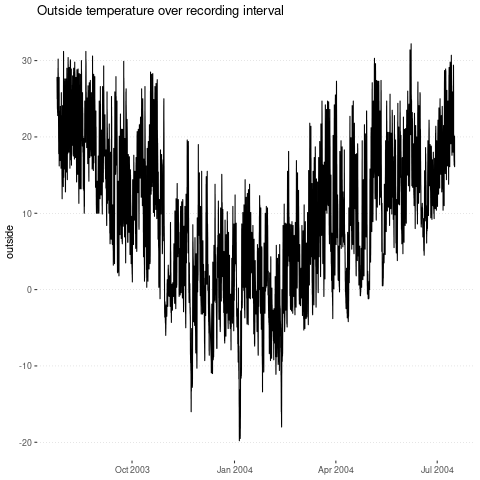

In [55]:
%%R
im <- ggplot(glarp, aes(x=timestamp, y=outside)) +
  geom_line() + clean_theme +
  ggtitle("Outside temperature over recording interval")
im

In [56]:
%%capture --no-stdout err
%%R
ggsave("img/(Ch05)Outside temperature over recording interval.png", dpi=600)

Saving 6.67 x 6.67 in image


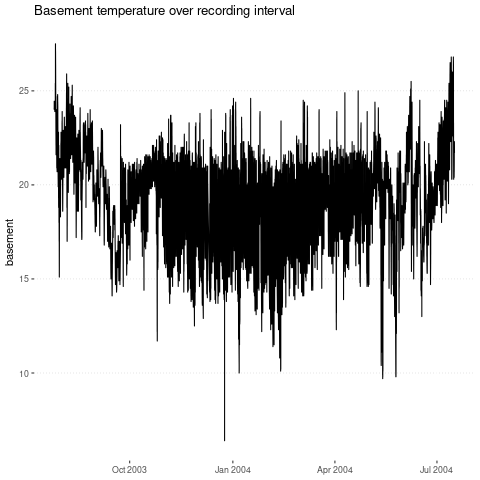

In [57]:
%%R
im <- ggplot(glarp, aes(x=timestamp, y=basement)) +
  geom_line() + clean_theme +
  ggtitle("Basement temperature over recording interval")
im

In [58]:
%%capture --no-stdout err
%%R
ggsave("img/(Ch05)Basement temperature over recording interval.png", dpi=600)

Saving 6.67 x 6.67 in image


### Domain Knowledge Trends

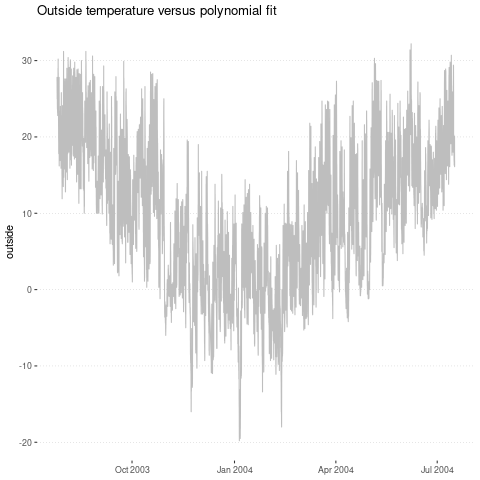

In [76]:
%%R
# # Model the data as a second order polynomial
# year.model <- lm(timestamp ~ poly(outside, 2), data = glarp)

# Display the regression and the data
im <- ggplot(glarp, aes(x=timestamp)) + clean_theme +
  geom_line(aes(y = outside), color = "gray") +
  # geom_line(aes(y = predict(year.model)), 
  #           color = "darkred", linewidth = 2) +
  ggtitle("Outside temperature versus polynomial fit") 
im

In [77]:
%%capture --no-stdout err
%%R    
ggsave("img/(Ch05)Outside temperature versus polynomial fit.png", dpi=600)

Saving 6.67 x 6.67 in image


In [78]:
%%R
outside <- glarp[, c("timestamp", "outside")] %>%
    add_column(no_seasonal = glarp$outside - predict(year.model))
outside

# A tibble: 171,349 × 3
   timestamp           outside  no_seasonal
   <dttm>                <dbl>        <dbl>
 1 2003-07-25 16:04:00    27.5 -1070713287.
 2 2003-07-25 16:07:00    27.3 -1070813977.
 3 2003-07-25 16:10:00    27.3 -1070813977.
 4 2003-07-25 16:13:00    27.4 -1070763760.
 5 2003-07-25 16:16:00    27.8 -1070560332.
 6 2003-07-25 16:19:00    27.5 -1070713287.
 7 2003-07-25 16:22:00    27.6 -1070662558.
 8 2003-07-25 16:25:00    27.6 -1070662558.
 9 2003-07-25 16:28:00    27.7 -1070611573.
10 2003-07-25 16:31:00    27.6 -1070675265.
# ℹ 171,339 more rows
# ℹ Use `print(n = ...)` to see more rows


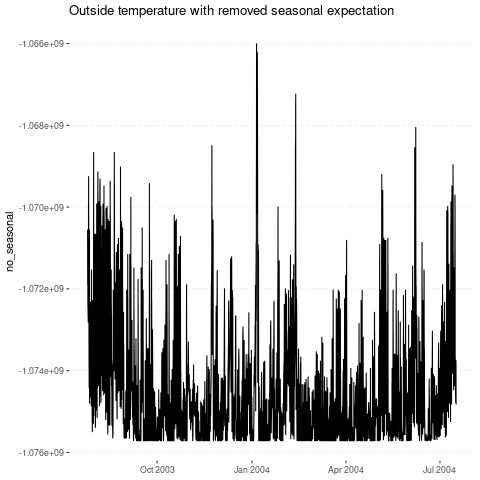

In [79]:
%%R
im <- ggplot(outside, aes(x=timestamp)) +
  geom_line(aes(y = no_seasonal)) + clean_theme +
  ggtitle("Outside temperature with removed seasonal expectation")
im

In [80]:
%%capture --no-stdout err
%%R
ggsave("img/(Ch05)Outside temperature with removed seasonal expectation.png", dpi=600)

Saving 6.67 x 6.67 in image


In [81]:
%%R
# Make one day add up to 2*pi radians
x <- 1:nrow(outside) * 2*pi / (24*60/3)
    
# Model the data as a first order trigometric regression
day_model <- lm(no_seasonal ~ sin(x) + cos(x), 
                data = outside)
print(day_model)

# Create a new tibble the holds the regression 
# and its removal from the annually detrended data
outside2 <- add_column(outside, 
                day_model = predict(day_model),
                no_daily = outside$no_seasonal - day_model)
outside2


Call:
lm(formula = no_seasonal ~ sin(x) + cos(x), data = outside)

Coefficients:
(Intercept)       sin(x)       cos(x)  
 -1.075e+09   -1.870e+04    3.194e+05  

# A tibble: 171,349 × 5
   timestamp           outside  no_seasonal    day_model no_daily
   <dttm>                <dbl>        <dbl>        <dbl>    <dbl>
 1 2003-07-25 16:04:00    27.5 -1070713287. -1074251217. 3537930.
 2 2003-07-25 16:07:00    27.3 -1070813977. -1074251544. 3437567.
 3 2003-07-25 16:10:00    27.3 -1070813977. -1074251926. 3437948.
 4 2003-07-25 16:13:00    27.4 -1070763760. -1074252362. 3488601.
 5 2003-07-25 16:16:00    27.8 -1070560332. -1074252852. 3692520.
 6 2003-07-25 16:19:00    27.5 -1070713287. -1074253397. 3540110.
 7 2003-07-25 16:22:00    27.6 -1070662558. -1074253996. 3591438.
 8 2003-07-25 16:25:00    27.6 -1070662558. -1074254650. 3592091.
 9 2003-07-25 16:28:00    27.7 -1070611573. -1074255357. 3643784.
10 2003-07-25 16:31:00    27.6 -1070675265. -1074256119. 3580854.
# ℹ 171,339 more rows

In addition: Warning messages:
1: Removed 3361 rows containing missing values or values outside the scale range
(`geom_line()`). 
2: Removed 3361 rows containing missing values or values outside the scale range
(`geom_line()`). 
3: Removed 3361 rows containing missing values or values outside the scale range
(`geom_line()`). 


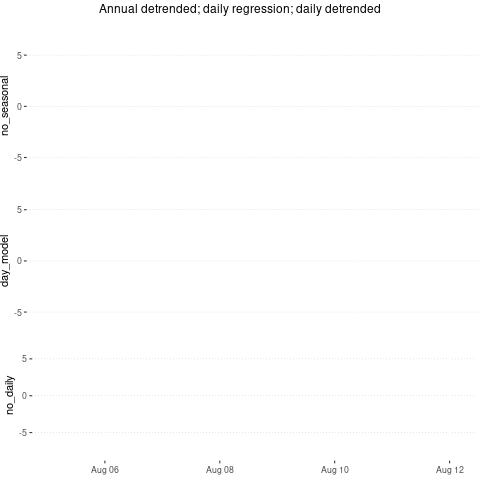

In [82]:
%%R
week <- outside2[5000:8360,]
p1 <- ggplot(week, aes(x = timestamp)) +
  no_xlabel + ylim(-8, +8) + 
  geom_line(aes(y = no_seasonal))
p2 <- ggplot(week, aes(x = timestamp)) +
  no_xlabel + ylim(-8, +8) + 
  geom_line(aes(y = day_model), color = "lightblue", size = 3)
p3 <- ggplot(week, aes(x = timestamp)) +
   clean_theme + ylim(-8, +8) +
  geom_line(aes(y = no_daily), color = "darkred")
grid.arrange(p1, p2, p3,
            top = "Annual detrended; daily regression; daily detrended")

In [56]:
%%capture --no-stdout err
%%R
ggsave("img/(Ch05)Annual detrended.png", plot=p1, dpi=600)
ggsave("img/(Ch05)Daily regression.png", plot=p2, dpi=600)
ggsave("img/(Ch05)Daily detrended.png", plot=p3, dpi=600)

### Discovered Cycles

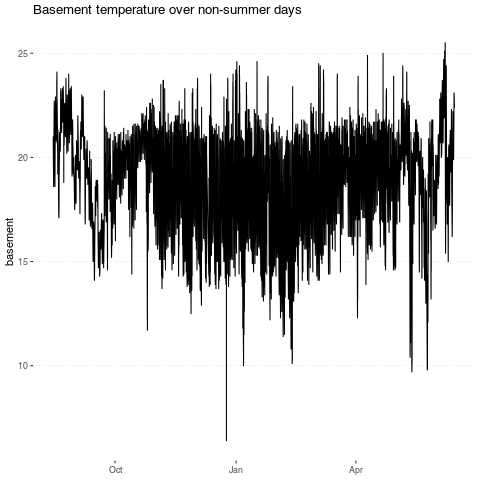

In [57]:
%%R
not_summer <- filter(glarp, 
                     timestamp >= as.Date("2003-08-15"), 
                     timestamp <= as.Date("2004-06-15")) 

# Plot only the non-summer days
im <- ggplot(not_summer, aes(x=timestamp, y=basement)) +
  geom_line() + clean_theme +
  ggtitle("Basement temperature over non-summer days")
im

In [58]:
%%capture --no-stdout err
%%R
ggsave("img/(Ch05)Basement temperature over non-summer days.png", plot=im, dpi=600)

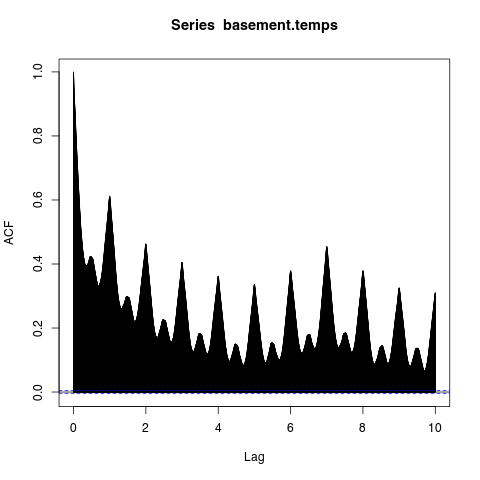

In [59]:
%%R
per_day <- 24*60/3
basement.temps <- ts(not_summer$basement, frequency = per_day)
auto <- acf(basement.temps, lag.max = 10*per_day)

In [60]:
%%capture --no-stdout err
%%R
png("img/(Ch05)basement.temps ACF.png", width=1200, height=800)
plot(auto)

## Bespoke validation

### Collation Validation

In [ ]:
# run in terminal as root
# download seqkit from https://bioinf.shenwei.me/seqkit/download/
wget https://github.com/shenwei356/seqkit/releases/download/v2.10.0/seqkit_linux_amd64.tar.gz
# extract the file
tar -zxvf *.tar.gz
# move it to the executables
mv seqkit /usr/local/bin/

In [85]:
%%bash
mkdir -p data/prokaryotes
cd data/prokaryotes
wget https://ddbj.nig.ac.jp/public/ddbj_database/16S/16S.fasta.gz
zcat 16S.fasta.gz | 
  seqkit rmdup --by-seq --ignore-case \
               -o clean.fasta.gz \
               -d duplicated.fasta.gz \
               -D duplicated.detail.txt

--2025-05-28 05:22:14--  https://ddbj.nig.ac.jp/public/ddbj_database/16S/16S.fasta.gz
Resolving ddbj.nig.ac.jp (ddbj.nig.ac.jp)... 133.39.233.36
Connecting to ddbj.nig.ac.jp (ddbj.nig.ac.jp)|133.39.233.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194176806 (185M) [application/x-gzip]
Saving to: ‘16S.fasta.gz’

     0K .......... .......... .......... .......... ..........  0%  226K 13m59s
    50K .......... .......... .......... .......... ..........  0%  225K 14m1s
   100K .......... .......... .......... .......... ..........  0% 39.3M 9m22s
   150K .......... .......... .......... .......... ..........  0% 16.5M 7m4s
   200K .......... .......... .......... .......... ..........  0%  201K 8m48s
   250K .......... .......... .......... .......... ..........  0%  100M 7m20s
   300K .......... .......... .......... .......... ..........  0%  165M 6m17s
   350K .......... .......... .......... .......... ..........  0%  107M 5m30s
   400K .......... .....

In [86]:
%%bash
cut -c-60 data/prokaryotes/duplicated.detail.txt | head

2718	CP002114_6|Staphylococcus, CP051165_4|Staphylococcus, C
2405	AE004091_1|Pseudomonas, AP014839_2|Pseudomonas, AP01483
2200	AP009048_3|Escherichia, AP009048_4|Escherichia, AP00924
1827	CP061514_1|Acinetobacter, CP061514_2|Acinetobacter, CP0
1670	CP024548_4|Klebsiella, CP024548_6|Klebsiella, CP033396_
1387	JN175331_1|Limosilactobacillus, MN464257_1|Limosilactob
1383	MN438326_1|Limosilactobacillus, MN438327_1|Limosilactob
1349	AB035922_1|Escherichia, AP009240_2|Escherichia, AP00924
1330	CP003166_2|Staphylococcus, CP003166_3|Staphylococcus, C
1330	AB100791_1|Lactococcus, AB100792_1|Lactococcus, AB10079


In [87]:
def matched_rna(dupfile):
    """Count of distinct organisms per sequence match
    
    Return a mapping from line number in the duplicates
    to Counters of occurrences of species names
    """
    counts = dict()
    for line in open(dupfile):
        line = line.rstrip()
        _, match_line = line.split('\t')
        matches = match_line.split(', ')
        first_id = matches[0].split('|')[0]
        names = [match.split('|')[1] for match in matches]
        count = Counter(names)
        counts[first_id] = count
    return counts

In [88]:
dupfile = 'data/prokaryotes/duplicated.detail.txt'
counts = matched_rna(dupfile)

In [89]:
print(counts['CP004752_1'])
print(counts['AB729796_1'])

Counter({'Mannheimia': 246, 'Pasteurellaceae': 1})
Counter({'Microbacterium': 62, 'Microbacteriaceae': 17})


In [90]:
counts['AB851397_1']

Counter({'Phyllobacteriaceae': 8, 'proteobacterium': 2, 'Proteobacteria': 1})

In [91]:
counts['CP020753_6']

Counter({'Escherichia': 511, 'Shigella': 42})

In [92]:
counts['FJ537133_1']

Counter({'Candidatus': 8,
         "'Trigonella": 6,
         "'Catharanthus": 4,
         "'Brassica": 3,
         "'Prunus": 2,
         "'Sesamum": 2,
         "'Empoasca": 2,
         'Aster': 1,
         "'Elaeis": 1,
         "'Tilia": 1,
         'Papaya': 1,
         "'Phalaris": 1,
         "'Eucalyptus": 1,
         "'Melochia": 1,
         'Chinaberry': 1,
         "'Sonchus": 1,
         'Periwinkle': 1,
         'Phytoplasma': 1,
         "'Zinnia": 1,
         "'Phyllanthus": 1,
         "'Parthenium": 1,
         "'Orosius": 1,
         'Empoasca': 1,
         "'Macrotyloma": 1,
         "'Vigna": 1,
         'Squash': 1})

### Transcription Validation

In [93]:
Sequence = namedtuple("FASTA", "recno ID name locus bp")

def get_sequence(fname):
    fasta = gzip.open(fname)
    pat = re.compile(r'n+')
    sequence = []
    recno = 0
    for line in fasta:
        line = line.decode('ASCII').strip()
        if line.startswith('>'):
            # Modify base pairs to contain single '-' 
            # rather than strings of 'n's 
            bp = "".join(sequence)
            bp = re.sub(pat, '-', bp)
            if recno > 0:
                yield Sequence(recno, ID, name, locus, bp)
            ID, name, locus = line[1:].split('|')
            sequence = []
            recno += 1
        else:
            sequence.append(line)

In [94]:
fname = 'data/prokaryotes/16S.fasta.gz'
prokaryotes = get_sequence(fname)
rec = next(prokaryotes)

print(rec.recno, rec.ID, rec.name, rec.locus)
print(fill(rec.bp, width=60))

1 AB000106_1 Sphingomonas sp. 16S ribosomal RNA
ggaatctgcccttgggttcggaataacgtctggaaacggacgctaataccggatgatgac
gtaagtccaaagatttatcgcccagggatgagcccgcgtaggattagctagttggtgagg
taaaggctcaccaaggcgacgatccttagctggtctgagaggatgatcagccacactggg
actgagacacggcccagactcctacgggaggcagcagtagggaatattggacaatgggcg
aaagcctgatccagcaatgccgcgtgagtgatgaaggccttagggttgtaaagctctttt
acccgggatgataatgacagtaccgggagaataagccccggctaactccgtgccagcagc
cgcggtaatacggagggggctagcgttgttcggaattactgggcgtaaagcgcacgtagg
cggcgatttaagtcagaggtgaaagcccggggctcaaccccggaatagcctttgagactg
gattgcttgaatccgggagaggtgagtggaattccgagtgtagaggtgaaattcgtagat
attcggaagaacaccagtggcgaaggcggatcactggaccggcattgacgctgaggtgcg
aaagcgtggggagcaaacaggattagataccctggtagtccacgccgtaaacgatgataa
ctagctgctggggctcatggagtttcagtggcgcagctaacgcattaagttatccgcctg
gggagtacggtcgcaagattaaaactcaaaggaattgacgggggcctgcacaagcggtgg
agcatgtggtttaattcgaagcaacgcgcagaaccttaccaacgtttgacatccctagta
tggttaccagagatggtttccttcagttcggctggctaggtgacaggtgctgcatggctg
tcgtcagctcgtgtcgtgagatgttgggttaagtccc

In [95]:
def find_dup_subseq(bp, minlen=45):
    count = Counter()
    for i in range(len(bp)-minlen):
        count[bp[i:i+minlen]] += 1
    return {seq: n for seq, n in count.items() if n > 1}

In [96]:
for seq in islice(get_sequence(fname), 2800):
    dup = find_dup_subseq(seq.bp)
    if dup:
        print(seq.recno, seq.ID, seq.name)
        pprint(dup)

2182 AB051695_1 Pseudomonas sp. LAB-16
{'gtcgagctagagtatggtagagggtggtggaatttcctgtgtagc': 2,
 'tcgagctagagtatggtagagggtggtggaatttcctgtgtagcg': 2}
2560 AB062283_1 Acinetobacter sp. ST-550
{'aaaggcctaccaaggcgacgatctgtagcgggtctgagaggatga': 2,
 'aaggcctaccaaggcgacgatctgtagcgggtctgagaggatgat': 2,
 'accaaggcgacgatctgtagcgggtctgagaggatgatccgccac': 2,
 'aggcctaccaaggcgacgatctgtagcgggtctgagaggatgatc': 2,
 'ccaaggcgacgatctgtagcgggtctgagaggatgatccgccaca': 2,
 'cctaccaaggcgacgatctgtagcgggtctgagaggatgatccgc': 2,
 'ctaccaaggcgacgatctgtagcgggtctgagaggatgatccgcc': 2,
 'gcctaccaaggcgacgatctgtagcgggtctgagaggatgatccg': 2,
 'ggcctaccaaggcgacgatctgtagcgggtctgagaggatgatcc': 2,
 'ggggtaaaggcctaccaaggcgacgatctgtagcgggtctgagag': 2,
 'gggtaaaggcctaccaaggcgacgatctgtagcgggtctgagagg': 2,
 'ggtaaaggcctaccaaggcgacgatctgtagcgggtctgagagga': 2,
 'ggtggggtaaaggcctaccaaggcgacgatctgtagcgggtctga': 2,
 'gtaaaggcctaccaaggcgacgatctgtagcgggtctgagaggat': 2,
 'gtggggtaaaggcctaccaaggcgacgatctgtagcgggtctgag': 2,
 'taaaggcctaccaaggc

## Exercises

### Data Characterization

In [97]:
%%bash
zcat data/glarp/lab.gz | head -5

2003 07 26 19 28 25.200000
2003 07 26 19 31 25.200000
2003 07 26 19 34 25.300000
2003 07 26 19 37 25.300000
2003 07 26 19 40 25.400000


In [98]:
%%bash
for f in data/glarp/*.gz; do 
    echo -n "$f: "
    zcat $f | wc -l 
done

data/glarp/basement.gz: 169516
data/glarp/lab.gz: 168965
data/glarp/livingroom.gz: 169516
data/glarp/outside.gz: 169513


### Oversampled Polls

In [99]:
pew = pd.read_csv('data/pew-survey.csv')
list(pew.q23a.unique())

['New technology makes people closer to their friends and family',
 'New technology makes people more isolated',
 '(VOL) Both equally',
 "(VOL) Don't know/Refused",
 '(VOL) Neither equally']

In [100]:
list(pew.q1.unique())

['Very happy', 'Pretty happy', 'Not too happy', "(VOL) Don't know/Refused"]

In [101]:
list(pew.timezone.unique())

['Eastern', 'Central', 'Mountain', 'Pacific']